**Packages à installer**

uv pip install simpledbf  
uv pip install geopandas

**Source des données d'entrée**

* EDC UDI - Communes et EDC résultats --> disponible dans la base duckdb, ou ici : https://www.data.gouv.fr/fr/datasets/resultats-du-controle-sanitaire-de-leau-distribuee-commune-par-commune/
* COG INSEE 2024 : https://www.insee.fr/fr/information/7766585 (lien direct vers le fichier CSV https://www.insee.fr/fr/statistiques/fichier/7766585/v_commune_2024.csv)
* IGN IRIS (Grande Echelle) 2024 : https://geoservices.ign.fr/irisge

In [2]:
import pandas as pd
import os
from simpledbf import Dbf5
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.ops import unary_union
import duckdb

os.chdir(os.path.dirname(os.getcwd()))
os.chdir(os.path.dirname(os.getcwd()))
from pipelines.tasks._common import DUCKDB_FILE

PyTables is not installed. No support for HDF output.
SQLalchemy is not installed. No support for SQL output.


In [3]:
repertoire_data = "C:\\Users\\simon\\Documents\\Data\\Pollution_eau\\data\\"
repertoire_data_edc = repertoire_data + "EDC"
repertoire_data_insee_cog = repertoire_data + "INSEE_COG"
repertoire_data_ign_iris = (
    repertoire_data
    + "IGN_IRIS\\1_DONNEES_LIVRAISON_2024-06-00156\\IRIS-GE_3-0_SHP_LAMB93_FXX-ED2024-01-01\\"
)

# Lecture des données

## Lecture des données EDC UDI - Communes
Correspond aux données EDC (Eau distribuée par commune)

In [4]:
os.chdir(repertoire_data_edc)
df_data_brut_comm_udi = pd.read_csv("DIS_COM_UDI_2024.txt")
print("Longueur de la table :", len(df_data_brut_comm_udi), "lignes")
df_data_brut_comm_udi.head()

Longueur de la table : 49555 lignes


,inseecommune,nomcommune,quartier,cdreseau,nomreseau,debutalim
0,01001,ABERGEMENT-CLEMENCIAT (L'),-,001000556,BDS ST DIDIER/CHALARONNE,2010-09-07
1,01002,ABERGEMENT-DE-VAREY (L'),-,001000369,L'ABERGEMENT-DE-VAREY,2010-09-07
2,01004,AMBERIEU-EN-BUGEY,Vareilles,001000248,AMBERIEU VAREILLES,2010-09-07
3,01004,AMBERIEU-EN-BUGEY,St Germain_Brédevent,001000249,AMBERIEU SAINT GERMAIN DOUVRES,2010-09-07
4,01004,AMBERIEU-EN-BUGEY,ville,001000251,AMBERIEU VILLE,2010-09-07


## Lecture des données EDC de résultats

In [5]:
os.chdir(repertoire_data_edc)
df_data_brut_edc_resultats = pd.read_csv("DIS_RESULT_2024.txt")
print("Longueur de la table :", len(df_data_brut_edc_resultats), "lignes")
df_data_brut_edc_resultats.head()

C:\Users\simon\AppData\Local\Temp\ipykernel_25964\155106084.py:2: DtypeWarning: Columns (0,1,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_data_brut_edc_resultats = pd.read_csv("DIS_RESULT_2024.txt")


Longueur de la table : 11931454 lignes


,cddept,referenceprel,cdparametresiseeaux,cdparametre,libmajparametre,libminparametre,libwebparametre,qualitparam,insituana,rqana,cdunitereferencesiseeaux,cdunitereference,limitequal,refqual,valtraduite,casparam,referenceanl
0,1,100138503,ALTMICR,1370.0,ALUMINIUM TOTAL µG/L,Aluminium total µg/l,NaN,N,L,<10,µg/L,133,NaN,<=200 µg/L,0.00,7429-90-5,100147233.0
1,1,100138503,ASP,6489.0,ASPECT (QUALITATIF),Aspect (qualitatif),NaN,O,L,Aspect normal,SANS OBJET,X,NaN,NaN,0.00,NaN,100147232.0
2,1,100138503,ASP,6489.0,ASPECT (QUALITATIF),Aspect (qualitatif),NaN,O,L,Aspect normal,SANS OBJET,X,NaN,NaN,0.00,NaN,100147233.0
3,1,100138503,CL2LIB,1398.0,CHLORE LIBRE,Chlore libre,NaN,N,T,"0,30",mg(Cl2)/L,165,NaN,NaN,0.30,NaN,NaN
4,1,100138503,CL2TOT,1399.0,CHLORE TOTAL,Chlore total,NaN,N,T,"0,34",mg(Cl2)/L,165,NaN,NaN,0.34,NaN,NaN


## Lecture des données COG INSEE (2024)
Contient les codes INSEE des communes et des arrondissements

In [6]:
os.chdir(repertoire_data_insee_cog)
df_data_brut_cog_insee_2024 = pd.read_csv("v_commune_2024.csv")
df_data_brut_cog_insee_2024.head()

,TYPECOM,COM,REG,DEP,CTCD,ARR,TNCC,NCC,NCCENR,LIBELLE,CAN,COMPARENT
0,COM,01001,84.0,01,01D,012,5,ABERGEMENT CLEMENCIAT,Abergement-Clémenciat,L'Abergement-Clémenciat,0108,NaN
1,COM,01002,84.0,01,01D,011,5,ABERGEMENT DE VAREY,Abergement-de-Varey,L'Abergement-de-Varey,0101,NaN
2,COM,01004,84.0,01,01D,011,1,AMBERIEU EN BUGEY,Ambérieu-en-Bugey,Ambérieu-en-Bugey,0101,NaN
3,COM,01005,84.0,01,01D,012,1,AMBERIEUX EN DOMBES,Ambérieux-en-Dombes,Ambérieux-en-Dombes,0122,NaN
4,COM,01006,84.0,01,01D,011,1,AMBLEON,Ambléon,Ambléon,0104,NaN


## Lecture table IGN IRIS
Données des IRIS de l'IGN sous forme de table (ci-dessous les données shapefile avec les contours)

In [7]:
os.chdir(repertoire_data_ign_iris)

# Lecture de la table
dbf = Dbf5("IRIS_GE.dbf")

# Conversion de la table en DataFrame
df_data_ign_iris = dbf.to_dataframe()

# Aperçu
df_data_ign_iris.head()

,ID,INSEE_COM,NOM_COM,IRIS,CODE_IRIS,NOM_IRIS,TYP_IRIS
0,IRIS____0000000670430101,67043,Bischheim,0101,670430101,Annexe,A
1,IRIS____0000000132020101,13202,Marseille 2e Arrondissement,0101,132020101,Arenc,A
2,IRIS____0000000561850101,56185,Quéven,0101,561850101,B.A.N. Lann Bihoué,A
3,IRIS____0000000930630101,93063,Romainville,0101,930630101,Bas Pays,A
4,IRIS____0000000940480101,94048,Marolles-en-Brie,0101,940480101,Bois de Notre-Dame,A


## Lecture shapefile IGN IRIS
Contours des IRIS

In [8]:
# Lecture du fichier
os.chdir(repertoire_data_ign_iris)
shp_ign_iris = gpd.read_file("IRIS_GE.shp")

# Aperçu
shp_ign_iris.head()

,ID,INSEE_COM,NOM_COM,IRIS,CODE_IRIS,NOM_IRIS,TYP_IRIS,geometry
0,IRIS____0000000670430101,67043,Bischheim,0101,670430101,Annexe,A,"POLYGON ((1050772.9 6847169.1, 1050902.2 68472..."
1,IRIS____0000000132020101,13202,Marseille 2e Arrondissement,0101,132020101,Arenc,A,"MULTIPOLYGON (((889986 6251412.3, 890200.1 625..."
2,IRIS____0000000561850101,56185,Quéven,0101,561850101,B.A.N. Lann Bihoué,A,"POLYGON ((216571.6 6760628.4, 216572.7 6760636..."
3,IRIS____0000000930630101,93063,Romainville,0101,930630101,Bas Pays,A,"POLYGON ((657944.3 6865938.3, 657957.7 6866026..."
4,IRIS____0000000940480101,94048,Marolles-en-Brie,0101,940480101,Bois de Notre-Dame,A,"POLYGON ((666452.1 6849977.7, 666590.8 6850199..."


## Connexion base de données duckdb

In [9]:
con = duckdb.connect(
    database=DUCKDB_FILE,
    read_only=True,
)

# Nettoyage de données

## Types de données

In [10]:
df_data_brut_cog_insee_2024.dtypes

TYPECOM       object
COM           object
REG          float64
DEP           object
CTCD          object
ARR           object
TNCC           int64
NCC           object
NCCENR        object
LIBELLE       object
CAN           object
COMPARENT    float64
dtype: object

## Valeurs nulles

In [11]:
df_data_brut_cog_insee_2024.isna().sum()

TYPECOM          0
COM              0
REG           2564
DEP           2564
CTCD          2564
ARR           2581
TNCC             0
NCC              0
NCCENR           0
LIBELLE          0
CAN           2620
COMPARENT    34935
dtype: int64

## Remplacement des valeurs nulles
**Non terminé, à poursuivre**

In [12]:
df_data_brut_cog_insee_incomplet = df_data_brut_cog_insee_2024[
    df_data_brut_cog_insee_2024["REG"].isna() == True
]

In [13]:
df_data_brut_cog_insee_complet = df_data_brut_cog_insee_2024[
    df_data_brut_cog_insee_2024["REG"].isna() == False
]

In [14]:
df_data_brut_cog_insee_incomplet.merge(
    df_data_brut_cog_insee_complet[["COM", "REG"]], on="COM"
)

,TYPECOM,COM,REG_x,DEP,CTCD,ARR,TNCC,NCC,NCCENR,LIBELLE,CAN,COMPARENT,REG_y
0,COMD,01015,NaN,NaN,NaN,NaN,1,ARBIGNIEU,Arbignieu,Arbignieu,NaN,1015.0,84.0
1,COMD,01025,NaN,NaN,NaN,NaN,0,BAGE LA VILLE,Bâgé-la-Ville,Bâgé-la-Ville,NaN,1025.0,84.0
2,COMD,01033,NaN,NaN,NaN,NaN,0,BELLEGARDE SUR VALSERINE,Bellegarde-sur-Valserine,Bellegarde-sur-Valserine,NaN,1033.0,84.0
3,COMD,01036,NaN,NaN,NaN,NaN,0,BELMONT LUTHEZIEU,Belmont-Luthézieu,Belmont-Luthézieu,NaN,1036.0,84.0
4,COMD,01080,NaN,NaN,NaN,NaN,0,CHAMPDOR,Champdor,Champdor,NaN,1080.0,84.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
568,COMD,89334,NaN,NaN,NaN,NaN,0,SAINT AUBIN CHATEAU NEUF,Saint-Aubin-Château-Neuf,Saint-Aubin-Château-Neuf,NaN,89334.0,27.0
569,COMD,89405,NaN,NaN,NaN,NaN,0,TAINGY,Taingy,Taingy,NaN,89405.0,27.0
570,COMD,89411,NaN,NaN,NaN,NaN,0,THEIL SUR VANNE,Theil-sur-Vanne,Theil-sur-Vanne,NaN,89411.0,27.0
571,COMD,89420,NaN,NaN,NaN,NaN,0,TREIGNY,Treigny,Treigny,NaN,89420.0,27.0


In [15]:
# df_data_brut_cog_insee_2024 = df_data_brut_cog_insee_2024.astype(
#     {"TYPECOM": str, "REG": int}
# )

In [16]:
df_data_brut_cog_insee_2024.dtypes

TYPECOM       object
COM           object
REG          float64
DEP           object
CTCD          object
ARR           object
TNCC           int64
NCC           object
NCCENR        object
LIBELLE       object
CAN           object
COMPARENT    float64
dtype: object

## Conversion colonne COMPARENT en integer

In [17]:
df_data_brut_cog_insee_2024["COMPARENT"] = (
    df_data_brut_cog_insee_2024["COMPARENT"].fillna(0).astype(int)
)

# Exploration de données

## Nombre de communes différentes

In [18]:
NB_COMMUNES_DIFFERENTES = len(pd.unique(df_data_brut_comm_udi["inseecommune"]))
print(
    "Nombre de communes pour lesquelles il existe au moins un relevé :",
    NB_COMMUNES_DIFFERENTES,
)

Nombre de communes pour lesquelles il existe au moins un relevé : 34880


## Vérification de la présence de toutes les communes de la table UDI-Communes dans la base COG INSEE

In [19]:
df_data_brut_comm_udi[
    df_data_brut_comm_udi["inseecommune"].isin(df_data_brut_cog_insee_2024["COM"])
    == False
]

,inseecommune,nomcommune,quartier,cdreseau,nomreseau,debutalim
49553,97701,SAINT-BARTHELEMY,Toute la commune,971000159,SAINT-BARTHELEMY,2010-10-19
49554,97801,SAINT-MARTIN,Toute la commune,971000160,SAINT-MARTIN,2010-10-19


## Existence de doublons dans la table COG INSEE ?

In [20]:
doublons_cog_insee = df_data_brut_cog_insee_2024[
    df_data_brut_cog_insee_2024.duplicated(subset="COM", keep=False)
]

doublons_cog_insee.head(16)

,TYPECOM,COM,REG,DEP,CTCD,ARR,TNCC,NCC,NCCENR,LIBELLE,CAN,COMPARENT
13,COM,01015,84.0,01,01D,011,1,ARBOYS EN BUGEY,Arboys en Bugey,Arboys en Bugey,0104,0
14,COMD,01015,NaN,NaN,NaN,NaN,1,ARBIGNIEU,Arbignieu,Arbignieu,NaN,1015
22,COM,01025,84.0,01,01D,012,0,BAGE DOMMARTIN,Bâgé-Dommartin,Bâgé-Dommartin,0117,0
23,COMD,01025,NaN,NaN,NaN,NaN,0,BAGE LA VILLE,Bâgé-la-Ville,Bâgé-la-Ville,NaN,1025
31,COM,01033,84.0,01,01D,014,0,VALSERHONE,Valserhône,Valserhône,0103,0
32,COMD,01033,NaN,NaN,NaN,NaN,0,BELLEGARDE SUR VALSERINE,Bellegarde-sur-Valserine,Bellegarde-sur-Valserine,NaN,1033
35,COM,01036,84.0,01,01D,011,0,VALROMEY SUR SERAN,Valromey-sur-Séran,Valromey-sur-Séran,0110,0
36,COMD,01036,NaN,NaN,NaN,NaN,0,BELMONT LUTHEZIEU,Belmont-Luthézieu,Belmont-Luthézieu,NaN,1036
77,COM,01080,84.0,01,01D,011,0,CHAMPDOR CORCELLES,Champdor-Corcelles,Champdor-Corcelles,0110,0
78,COMD,01080,NaN,NaN,NaN,NaN,0,CHAMPDOR,Champdor,Champdor,NaN,1080


Les doublons semblent être sur le TYPECOM "COMD" (commune déléguée)

### Est-ce que les doublons concernent tous des COMD (communes déléguées) ?

In [21]:
doublons_cog_insee_sans_comd = doublons_cog_insee[
    doublons_cog_insee["TYPECOM"] != "COMD"
]

doublons_cog_insee_sans_comd = doublons_cog_insee_sans_comd[
    doublons_cog_insee_sans_comd.duplicated(subset="COM", keep=False)
]

doublons_cog_insee_sans_comd.head()

,TYPECOM,COM,REG,DEP,CTCD,ARR,TNCC,NCC,NCCENR,LIBELLE,CAN,COMPARENT


Une fois les "COMD" supprimées, il n'y a plus de doublons. Donc **tous les doublons correspondent à des communes déléguées**.

--> Pour l'instant on conserve les COMD mais il faudra peut-être les supprimer si ce n'est pas pertinent.

## Nombre d'UDI uniques
Dans la doc (https://www.data.gouv.fr/fr/datasets/r/36afc708-42dc-4a89-b039-7fde6bcc83d8), le champ cdreseau est défini comme : "Code d’identification du réseau de distribution (installation de type unité de distribution)"

In [22]:
NB_UDI_DIFFERENTES = len(pd.unique(df_data_brut_comm_udi["cdreseau"]))
print(
    "Nombre d'UDI uniques :",
    NB_UDI_DIFFERENTES,
)

Nombre d'UDI uniques : 23243


## Toutes les communes présentes dans EDC sont-elles dans la base IGN IRIS ?

In [23]:
df_data_ign_iris.head()

,ID,INSEE_COM,NOM_COM,IRIS,CODE_IRIS,NOM_IRIS,TYP_IRIS
0,IRIS____0000000670430101,67043,Bischheim,0101,670430101,Annexe,A
1,IRIS____0000000132020101,13202,Marseille 2e Arrondissement,0101,132020101,Arenc,A
2,IRIS____0000000561850101,56185,Quéven,0101,561850101,B.A.N. Lann Bihoué,A
3,IRIS____0000000930630101,93063,Romainville,0101,930630101,Bas Pays,A
4,IRIS____0000000940480101,94048,Marolles-en-Brie,0101,940480101,Bois de Notre-Dame,A


In [24]:
df_data_ign_iris.dtypes

ID           object
INSEE_COM    object
NOM_COM      object
IRIS         object
CODE_IRIS    object
NOM_IRIS     object
TYP_IRIS     object
dtype: object

In [25]:
df_data_brut_comm_udi.dtypes

inseecommune    object
nomcommune      object
quartier        object
cdreseau        object
nomreseau       object
debutalim       object
dtype: object

In [26]:
valeurs_absentes = df_data_brut_comm_udi[
    ~df_data_brut_comm_udi["inseecommune"].isin(df_data_ign_iris["INSEE_COM"])
]

# Afficher les résultats
print(
    "Nombre de codes inseecommune (issu des données EDC) uniques absents dans les données IGN IRIS :",
    len(valeurs_absentes["inseecommune"].unique()),
)
print("Valeurs absentes :")
valeurs_absentes.head()

Nombre de codes inseecommune (issu des données EDC) uniques absents dans les données IGN IRIS : 134
Valeurs absentes :


,inseecommune,nomcommune,quartier,cdreseau,nomreseau,debutalim
6686,13055,MARSEILLE,MARSEILLE NORD,013000519,MARSEILLE VALLON D'OL,2010-08-07
6687,13055,MARSEILLE,MARSEILLE EST,013000521,MARSEILLE ST BARNABE,2010-08-07
6688,13055,MARSEILLE,MARSEILLE CENTRE ET SUD,013000577,MARSEILLE SAINTE-MARTHE,2010-08-07
6689,13055,MARSEILLE,port maritime,013006573,GRAND PORT MARITIME MARSEILLE EST SEM 11,2019-05-10
6690,13055,MARSEILLE,port maritime,013006613,GRAND PORT MARITIME MARSEILLE EST SEM 2,2019-11-08


### Etude détaillée des écarts avec le code INSEE 13055 qui n'est pas dans les données IGN IRIS

In [27]:
df_data_brut_comm_udi[df_data_brut_comm_udi["inseecommune"] == "13055"]

,inseecommune,nomcommune,quartier,cdreseau,nomreseau,debutalim
6686,13055,MARSEILLE,MARSEILLE NORD,013000519,MARSEILLE VALLON D'OL,2010-08-07
6687,13055,MARSEILLE,MARSEILLE EST,013000521,MARSEILLE ST BARNABE,2010-08-07
6688,13055,MARSEILLE,MARSEILLE CENTRE ET SUD,013000577,MARSEILLE SAINTE-MARTHE,2010-08-07
6689,13055,MARSEILLE,port maritime,013006573,GRAND PORT MARITIME MARSEILLE EST SEM 11,2019-05-10
6690,13055,MARSEILLE,port maritime,013006613,GRAND PORT MARITIME MARSEILLE EST SEM 2,2019-11-08
6691,13055,MARSEILLE,port maritime,013006614,GRAND PORT MARITIME MARSEILLE EST SEM 3,2019-11-08
6692,13055,MARSEILLE,port maritime,013006615,GRAND PORT MARITIME MARSEILLE EST SEM 4,2019-11-08
6693,13055,MARSEILLE,port maritime,013006616,GRAND PORT MARITIME MARSEILLE EST SEM 5,2019-11-08
6694,13055,MARSEILLE,port maritime,013006617,GRAND PORT MARITIME MARSEILLE ST CAS.SUD,2019-11-08
6695,13055,MARSEILLE,port maritime,013006618,GRAND PORT MARITIME MARSEILLE ST CAS.N,2019-11-08


In [ ]:
df_data_ign_iris[df_data_ign_iris["INSEE_COM"] == "13055"]

,ID,INSEE_COM,NOM_COM,IRIS,CODE_IRIS,NOM_IRIS,TYP_IRIS


In [29]:
# Exemple avec code INSEE_COM 13202 qui correspond à un IRIS de Marseille
df_data_ign_iris[df_data_ign_iris["INSEE_COM"] == "13202"]

,ID,INSEE_COM,NOM_COM,IRIS,CODE_IRIS,NOM_IRIS,TYP_IRIS
1,IRIS____0000000132020101,13202,Marseille 2e Arrondissement,0101,132020101,Arenc,A
9433,IRIS____0000000132020201,13202,Marseille 2e Arrondissement,0201,132020201,Montolieu,H
9719,IRIS____0000000132020202,13202,Marseille 2e Arrondissement,0202,132020202,Les Carmes,H
9898,IRIS____0000000132020203,13202,Marseille 2e Arrondissement,0203,132020203,Dames,H
10109,IRIS____0000000132020204,13202,Marseille 2e Arrondissement,0204,132020204,Panier,H
10144,IRIS____0000000132020205,13202,Marseille 2e Arrondissement,0205,132020205,Charité République,H
10501,IRIS____0000000132020301,13202,Marseille 2e Arrondissement,0301,132020301,Quai du Port,H
10754,IRIS____0000000132020302,13202,Marseille 2e Arrondissement,0302,132020302,Saint-Jean-Protis,H
10837,IRIS____0000000132020303,13202,Marseille 2e Arrondissement,0303,132020303,Hôtel-Dieu,H
11220,IRIS____0000000132020401,13202,Marseille 2e Arrondissement,0401,132020401,L'Évêché-Les Docks,H


In [74]:
# Test sur Strasbourg qui a des IRIS mais pas d'arrondissements
df_data_ign_iris[df_data_ign_iris["NOM_COM"].str.startswith("Strasbourg")]

,ID,INSEE_COM,NOM_COM,IRIS,CODE_IRIS,NOM_IRIS,TYP_IRIS
525,IRIS____0000000674820501,67482,Strasbourg,0501,674820501,Kable Nord,A
658,IRIS____0000000674821205,67482,Strasbourg,1205,674821205,Neudorf Ouest Nord-Ouest,A
663,IRIS____0000000674821303,67482,Strasbourg,1303,674821303,Elsau Est,A
679,IRIS____0000000674821604,67482,Strasbourg,1604,674821604,Koenigshoffen Ouest Nord-Est,A
681,IRIS____0000000674821605,67482,Strasbourg,1605,674821605,Koenigshoffen Ouest Sud,A
...,...,...,...,...,...,...,...
14696,IRIS____0000000674822901,67482,Strasbourg,2901,674822901,Neuhof Nord,H
14702,IRIS____0000000674822902,67482,Strasbourg,2902,674822902,Neuhof Sud,H
14714,IRIS____0000000674823001,67482,Strasbourg,3001,674823001,Stockfeld Est,H
14719,IRIS____0000000674823002,67482,Strasbourg,3002,674823002,Stockfeld Ouest,H


**Conclusion sur les codes INSEE absents : la base IGN IRIS semble être découpée selon les arrondissements dans les villes dans lesquelles il y en a.
Par exemple pour Marseille ce sont les codes INSEE des arrondissements qui sont dans la base, et pas celui de la ville de Marseille.
C'est confirmé avec le cas de Strasbourg, qui une commune qui contient plusieurs IRIS mais pas d'arrondissements : le code INSEE est celui de la ville
pour tous les IRIS.**

Question : comment faire le lien entre les codes INSEE des communes et les codes INSEE des arrondissements ?

In [30]:
df_data_brut_cog_insee_2024[
    (df_data_brut_cog_insee_2024["COM"] == "13055")
    | (df_data_brut_cog_insee_2024["COM"] == "13202")
]

,TYPECOM,COM,REG,DEP,CTCD,ARR,TNCC,NCC,NCCENR,LIBELLE,CAN,COMPARENT
4533,COM,13055,93.0,13,13D,133,0,MARSEILLE,Marseille,Marseille,1398,0
4599,ARM,13202,93.0,13,13D,133,0,MARSEILLE 2E ARRONDISSEMENT,Marseille 2e Arrondissement,Marseille 2e Arrondissement,1398,13055


**Lien entre le code INSEE de la commune et le code INSEE de l'arrondissement peut être fait grâce à la table INSEE COG**

**Question : pour les communes avec arrondissements, est-ce qu'on veut un détail pour la commune entière ou pour chaque arrondissement ?**  
--> Réponse donnée en point hebdo du 07/02 : on reste sur la maille commune.

### Test pour Paris

In [31]:
df_data_brut_comm_udi[df_data_brut_comm_udi["inseecommune"] == "75056"]

,inseecommune,nomcommune,quartier,cdreseau,nomreseau,debutalim
41935,75056,PARIS,"du 1° au 13°, 15° et 16° arrondissement",075000221,CENTRE,2010-09-02
41936,75056,PARIS,"8° à 10°, 16° à 18° arrondissement",075000222,NORD OUEST,2010-09-02
41937,75056,PARIS,"5°, 6°, 13° à 16° arrondissement",075000225,SUD OUEST,2010-09-02
41938,75056,PARIS,"12°,19°, 20°, est des 10, 11,18",075000227,EST,2010-09-02


Plusieurs UDI pour Paris, chacune correspondant à plusieurs arrondissements. **Mais certains arrondissements sont desservis par plusieurs UDI différentes**

--> Est-ce que c'est le cas pour d'autres communes ?

## Comparaison bases IGN IRIS et COG INSEE

In [81]:
# Communes de IGN IRIS absentes de COG INSEE
print("Communes de IGN IRIS absentes de COG INSEE :")
df_data_ign_iris[~df_data_ign_iris["INSEE_COM"].isin(df_data_brut_cog_insee_2024["COM"])]

Communes de IGN IRIS absentes de COG INSEE :


,ID,INSEE_COM,NOM_COM,IRIS,CODE_IRIS,NOM_IRIS,TYP_IRIS


In [91]:
# Communes de COG INSEE absentes de IGN IRIS
# (on ne garde que les types = communes (COM))
com_absentes_cog_insee = df_data_brut_cog_insee_2024[~(df_data_brut_cog_insee_2024["COM"].isin(df_data_ign_iris["INSEE_COM"])) & (df_data_brut_cog_insee_2024["TYPECOM"]=="COM")]
print("Communes de COG INSEE absentes de IGN IRIS :")
com_absentes_cog_insee["COM"].unique()

Communes de COG INSEE absentes de IGN IRIS :


array(['13055', '69123', '75056', '97101', '97102', '97103', '97104',
       '97105', '97106', '97107', '97108', '97109', '97110', '97111',
       '97112', '97113', '97114', '97115', '97116', '97117', '97118',
       '97119', '97120', '97121', '97122', '97124', '97125', '97126',
       '97128', '97129', '97130', '97131', '97132', '97133', '97134',
       '97201', '97202', '97203', '97204', '97205', '97206', '97207',
       '97208', '97209', '97210', '97211', '97212', '97213', '97214',
       '97215', '97216', '97217', '97218', '97219', '97220', '97221',
       '97222', '97223', '97224', '97225', '97226', '97227', '97228',
       '97229', '97230', '97231', '97232', '97233', '97234', '97301',
       '97302', '97303', '97304', '97305', '97306', '97307', '97308',
       '97309', '97310', '97311', '97312', '97313', '97314', '97352',
       '97353', '97356', '97357', '97358', '97360', '97361', '97362',
       '97401', '97402', '97403', '97404', '97405', '97406', '97407',
       '97408', '974

--> Il semble n'y avoir que les villes avec arrondissements (Paris, Lyon, Marseille) et les communes des DROM

In [ ]:
# Vérification que les DROM sont bien présents dans COG INSEE
df_data_brut_cog_insee_2024[df_data_brut_cog_insee_2024["COM"]==df_data_brut_cog_insee_2024["COM"].max()]

,TYPECOM,COM,REG,DEP,CTCD,ARR,TNCC,NCC,NCCENR,LIBELLE,CAN,COMPARENT
37543,COM,97617,6.0,976,976D,NaN,0,TSINGONI,Tsingoni,Tsingoni,97613,0


In [ ]:
# Vérification que les DROM sont bien absents de IGN IRIS
df_data_ign_iris[df_data_ign_iris["INSEE_COM"]==df_data_ign_iris["INSEE_COM"].max()]

,ID,INSEE_COM,NOM_COM,IRIS,CODE_IRIS,NOM_IRIS,TYP_IRIS
48456,IRIS____0000000956900000,95690,Wy-dit-Joli-Village,0000,956900000,Wy-dit-Joli-Village,Z


**Conclusion de l'étude des écarts de communes entre IGN IRIS et COG INSEE :  
La base IGN IRIS ne contient pas les DROM (sujet des arrondissements déjà vu plus haut)**

## Communes avec plusieurs UDI

In [32]:
df_data_brut_comm_udi[df_data_brut_comm_udi["inseecommune"].duplicated()]

,inseecommune,nomcommune,quartier,cdreseau,nomreseau,debutalim
3,01004,AMBERIEU-EN-BUGEY,St Germain_Brédevent,001000249,AMBERIEU SAINT GERMAIN DOUVRES,2010-09-07
4,01004,AMBERIEU-EN-BUGEY,ville,001000251,AMBERIEU VILLE,2010-09-07
6,01005,AMBERIEUX-EN-DOMBES,Ouest,001000850,BDS CHATANIER,2021-08-01
10,01008,AMBUTRIX,montée de Carrouge,001000255,AMBUTRIX MONTEE DE CARROUGE,2010-09-07
13,01010,ANGLEFORT,Rhémoz,001000261,ANGLEFORT RHEMOZ,2010-09-07
...,...,...,...,...,...,...
49544,97613,M'TSANGAMOUJI,VILLAGE MLIHA,976003883,RESEAU ACOUA MLIHA,2019-06-25
49547,97615,PAMANDZI,- La vigie,976003554,LA VIGIE DE PAMANDZI,2015-05-04
49550,97617,TSINGONI,MIRERENI VILLAGE,976000059,MIRERENI COMBANI,2013-05-30
49551,97617,TSINGONI,MROUALE VILLAGE,976000059,MIRERENI COMBANI,2013-05-30


In [33]:
df_data_brut_comm_udi[df_data_brut_comm_udi["inseecommune"] == "01004"]

,inseecommune,nomcommune,quartier,cdreseau,nomreseau,debutalim
2,01004,AMBERIEU-EN-BUGEY,Vareilles,001000248,AMBERIEU VAREILLES,2010-09-07
3,01004,AMBERIEU-EN-BUGEY,St Germain_Brédevent,001000249,AMBERIEU SAINT GERMAIN DOUVRES,2010-09-07
4,01004,AMBERIEU-EN-BUGEY,ville,001000251,AMBERIEU VILLE,2010-09-07


### Croisement des données EDC, IGN IRIS et INSEE COG
**Non terminé, à poursuivre**

In [34]:
df_data_ign_iris

,ID,INSEE_COM,NOM_COM,IRIS,CODE_IRIS,NOM_IRIS,TYP_IRIS
0,IRIS____0000000670430101,67043,Bischheim,0101,670430101,Annexe,A
1,IRIS____0000000132020101,13202,Marseille 2e Arrondissement,0101,132020101,Arenc,A
2,IRIS____0000000561850101,56185,Quéven,0101,561850101,B.A.N. Lann Bihoué,A
3,IRIS____0000000930630101,93063,Romainville,0101,930630101,Bas Pays,A
4,IRIS____0000000940480101,94048,Marolles-en-Brie,0101,940480101,Bois de Notre-Dame,A
...,...,...,...,...,...,...,...
48564,IRIS____00000002B3640000,2B364,Zuani,0000,2B3640000,Zuani,Z
48565,IRIS____0000000629050000,62905,Zudausques,0000,629050000,Zudausques,Z
48566,IRIS____0000000629060000,62906,Zutkerque,0000,629060000,Zutkerque,Z
48567,IRIS____0000000596680000,59668,Zuydcoote,0000,596680000,Zuydcoote,Z


In [35]:
merge = df_data_brut_comm_udi.merge(
    df_data_brut_cog_insee_2024, left_on="inseecommune", right_on="COM"
)

merge[merge["inseecommune"] == "13055"]

,inseecommune,nomcommune,quartier,cdreseau,nomreseau,debutalim,TYPECOM,COM,REG,DEP,CTCD,ARR,TNCC,NCC,NCCENR,LIBELLE,CAN,COMPARENT
6887,13055,MARSEILLE,MARSEILLE NORD,013000519,MARSEILLE VALLON D'OL,2010-08-07,COM,13055,93.0,13,13D,133,0,MARSEILLE,Marseille,Marseille,1398,0
6888,13055,MARSEILLE,MARSEILLE EST,013000521,MARSEILLE ST BARNABE,2010-08-07,COM,13055,93.0,13,13D,133,0,MARSEILLE,Marseille,Marseille,1398,0
6889,13055,MARSEILLE,MARSEILLE CENTRE ET SUD,013000577,MARSEILLE SAINTE-MARTHE,2010-08-07,COM,13055,93.0,13,13D,133,0,MARSEILLE,Marseille,Marseille,1398,0
6890,13055,MARSEILLE,port maritime,013006573,GRAND PORT MARITIME MARSEILLE EST SEM 11,2019-05-10,COM,13055,93.0,13,13D,133,0,MARSEILLE,Marseille,Marseille,1398,0
6891,13055,MARSEILLE,port maritime,013006613,GRAND PORT MARITIME MARSEILLE EST SEM 2,2019-11-08,COM,13055,93.0,13,13D,133,0,MARSEILLE,Marseille,Marseille,1398,0
6892,13055,MARSEILLE,port maritime,013006614,GRAND PORT MARITIME MARSEILLE EST SEM 3,2019-11-08,COM,13055,93.0,13,13D,133,0,MARSEILLE,Marseille,Marseille,1398,0
6893,13055,MARSEILLE,port maritime,013006615,GRAND PORT MARITIME MARSEILLE EST SEM 4,2019-11-08,COM,13055,93.0,13,13D,133,0,MARSEILLE,Marseille,Marseille,1398,0
6894,13055,MARSEILLE,port maritime,013006616,GRAND PORT MARITIME MARSEILLE EST SEM 5,2019-11-08,COM,13055,93.0,13,13D,133,0,MARSEILLE,Marseille,Marseille,1398,0
6895,13055,MARSEILLE,port maritime,013006617,GRAND PORT MARITIME MARSEILLE ST CAS.SUD,2019-11-08,COM,13055,93.0,13,13D,133,0,MARSEILLE,Marseille,Marseille,1398,0
6896,13055,MARSEILLE,port maritime,013006618,GRAND PORT MARITIME MARSEILLE ST CAS.N,2019-11-08,COM,13055,93.0,13,13D,133,0,MARSEILLE,Marseille,Marseille,1398,0


## Exploration contours IRIS de l'IGN

In [36]:
print(shp_ign_iris.crs)

EPSG:2154


In [37]:
shp_ign_iris = shp_ign_iris.to_crs(epsg=2154)

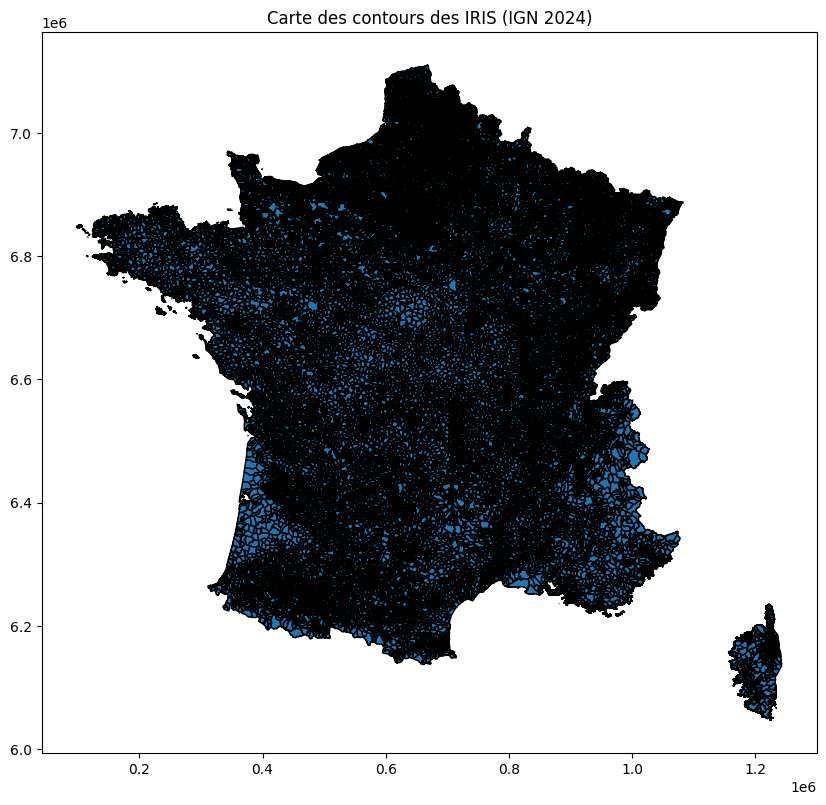

In [38]:
fig, ax = plt.subplots(figsize=(10, 10))
shp_ign_iris.plot(ax=ax, edgecolor="black")
plt.title("Carte des contours des IRIS (IGN 2024)")
plt.show()

## Exploration base duckdb

In [39]:
# Récupération des noms des tables présentes dans la BDD
query = "SELECT name FROM sqlite_schema WHERE type = 'table';"

# Exécution de la requête
tables = con.execute(query).fetchall()

# Affichage des noms des tables
table_names = [table[0] for table in tables]
print("Tables dans la base de données :", table_names)

Tables dans la base de données : ['edc_communes', 'edc_prelevements', 'edc_resultats']


In [40]:
# Lecture table communes
df_duckdb_communes = con.table("edc_communes").to_df()

# Aperçu
df_duckdb_communes.head()

,inseecommune,nomcommune,quartier,cdreseau,nomreseau,debutalim,de_partition,de_ingestion_date
0,01001,ABERGEMENT-CLEMENCIAT (L'),-,001000556,BDS ST DIDIER/CHALARONNE,2010-09-07,2024,2025-02-09
1,01002,ABERGEMENT-DE-VAREY (L'),-,001000369,L'ABERGEMENT-DE-VAREY,2010-09-07,2024,2025-02-09
2,01004,AMBERIEU-EN-BUGEY,Vareilles,001000248,AMBERIEU VAREILLES,2010-09-07,2024,2025-02-09
3,01004,AMBERIEU-EN-BUGEY,St Germain_Brédevent,001000249,AMBERIEU SAINT GERMAIN DOUVRES,2010-09-07,2024,2025-02-09
4,01004,AMBERIEU-EN-BUGEY,ville,001000251,AMBERIEU VILLE,2010-09-07,2024,2025-02-09


In [41]:
# Calcul du nombre de communes uniques
nombre_de_communes = df_duckdb_communes.nunique()["inseecommune"]
print(f"Nombre de communes uniques = {nombre_de_communes}")

Nombre de communes uniques = 34809


In [42]:
# Vérfication que les données dans duckdb sont exactement les mêmes que les données EDC comm-udi téléchargées
# Uniformisation des formats
df_duckdb_communes = df_duckdb_communes.astype(df_data_brut_comm_udi.dtypes)
df_duckdb_communes["debutalim"] = df_duckdb_communes["debutalim"].astype(str)
df_duckdb_communes["debutalim"] = df_duckdb_communes["debutalim"].str[0:10]
df_data_brut_comm_udi["debutalim"] = df_data_brut_comm_udi["debutalim"].astype(str)

# Ajout colonne d'identification du DataFrame
df_duckdb_communes["source"] = "duckdb"
df_data_brut_comm_udi["source"] = "edc"

# Réorganisation des colonnes
colonnes = ['source'] + [col for col in df_duckdb_communes.columns if col != 'source']
df_duckdb_communes = df_duckdb_communes[colonnes]
colonnes = ['source'] + [col for col in df_data_brut_comm_udi.columns if col != 'source']
df_data_brut_comm_udi = df_data_brut_comm_udi[colonnes]

# Comparaison des dataframes (sur les colonnes communes et hors colonne "source")
are_equal = df_data_brut_comm_udi.iloc[:, 1:6].equals(df_duckdb_communes.iloc[:, 1:6])
print("Les dataframes sont équivalents :", are_equal)

Les dataframes sont équivalents : False


In [48]:
# Affichage des lignes différentes entre les deux dataframes
# Concaténer les DataFrames
combined = pd.concat([df_duckdb_communes.iloc[:, 0:7], df_data_brut_comm_udi.iloc[:, 0:7]])

# Identifier les lignes dupliquées
duplicates = combined.iloc[:, 1:7].duplicated(keep=False)

# Filtrer les lignes qui ne sont pas des doublons
differences = combined[~duplicates]

# Afficher les différences
print("Nombre de lignes différentes :", len(differences))
print("Lignes différentes entre les deux DataFrames :")
differences.head()

Nombre de lignes différentes : 1117
Lignes différentes entre les deux DataFrames :


,source,inseecommune,nomcommune,quartier,cdreseau,nomreseau,debutalim
630,duckdb,02109,BOUTEILLE (LA),-,002001353,UDI DEMI LIEUE ORIGNY EN THIERACHE,2010-08-10
631,duckdb,02109,BOUTEILLE (LA),-,002004276,UDI LE CHAUDRON ORIGNY EN THIERACHE,2024-07-01
651,duckdb,02130,BUCILLY,-,002001353,UDI DEMI LIEUE ORIGNY EN THIERACHE,2010-08-10
656,duckdb,02134,BUIRE,Centre Ville,002001353,UDI DEMI LIEUE ORIGNY EN THIERACHE,2010-08-10
800,duckdb,02275,EFFRY,-,002001353,UDI DEMI LIEUE ORIGNY EN THIERACHE,2010-08-10


In [49]:
# Exemple de différence
differences[differences["inseecommune"] == "02130"]

,source,inseecommune,nomcommune,quartier,cdreseau,nomreseau,debutalim
651,duckdb,02130,BUCILLY,-,002001353,UDI DEMI LIEUE ORIGNY EN THIERACHE,2010-08-10
651,edc,02130,BUCILLY,-,002001353,SIAEP D'ORIGNY EN THIERACHE,2010-08-10


### Est-ce que toutes les communes de la base duckdb sont retrouvées dans la base communes COG INSEE ?

In [100]:
# Communes présentes dans la base DUCKDB mais pas dans la base INSEE
print("Communes présentes dans la base DUCKDB mais pas dans la base INSEE :")
df_duckdb_communes[~df_duckdb_communes["inseecommune"].isin(df_data_brut_cog_insee_2024["COM"])]

Communes présentes dans la base DUCKDB mais pas dans la base INSEE :


,source,inseecommune,nomcommune,quartier,cdreseau,nomreseau,debutalim,de_partition,de_ingestion_date
49534,duckdb,97701,SAINT-BARTHELEMY,Toute la commune,971000159,SAINT-BARTHELEMY,2010-10-19,2024,2025-02-09
49535,duckdb,97801,SAINT-MARTIN,Toute la commune,971000160,SAINT-MARTIN,2010-10-19,2024,2025-02-09


In [108]:
# Communes présentes dans les données INSEE mais pas dans la base DUCKDB
print("Communes présentes dans les données INSEE mais pas dans la base DUCKDB :")
df_data_brut_cog_insee_2024[~(df_data_brut_cog_insee_2024["COM"].isin(df_duckdb_communes["inseecommune"])) & (df_data_brut_cog_insee_2024["TYPECOM"]=="COM")]

Communes présentes dans les données INSEE mais pas dans la base DUCKDB :


,TYPECOM,COM,REG,DEP,CTCD,ARR,TNCC,NCC,NCCENR,LIBELLE,CAN,COMPARENT
307,COM,01330,84.0,01,01D,011,0,RUFFIEU,Ruffieu,Ruffieu,0110,0
739,COM,02311,32.0,02,02D,024,0,FILAIN,Filain,Filain,0205,0
1747,COM,04191,93.0,04,04D,043,0,SAINT MARTIN LES SEYNE,Saint-Martin-lès-Seyne,Saint-Martin-lès-Seyne,0413,0
1839,COM,05053,93.0,05,05D,052,0,GARDE COLOMBE,Garde-Colombe,Garde-Colombe,0513,0
1940,COM,05159,93.0,05,05D,052,0,SALEON,Saléon,Saléon,0513,0
...,...,...,...,...,...,...,...,...,...,...,...,...
35240,COM,85233,52.0,85,85D,851,0,SAINT JEAN DE BEUGNE,Saint-Jean-de-Beugné,Saint-Jean-de-Beugné,8504,0
36197,COM,88393,44.0,88,88D,882,0,ROLLAINVILLE,Rollainville,Rollainville,8810,0
36870,COM,90061,27.0,90,90D,901,0,LAMADELEINE VAL DES ANGES,Lamadeleine-Val-des-Anges,Lamadeleine-Val-des-Anges,9007,0
37171,COM,93059,11.0,93,93D,933,0,PIERREFITTE SUR SEINE,Pierrefitte-sur-Seine,Pierrefitte-sur-Seine,9309,0


# Croisement tables UDI-Communes et COG INSEE

In [45]:
df_data_udi_comm_augmente = pd.merge(
    df_data_brut_comm_udi,
    df_data_brut_cog_insee_2024,
    left_on="inseecommune",
    right_on="COM",
    how="left",
)

df_data_udi_comm_augmente

,source,inseecommune,nomcommune,quartier,cdreseau,nomreseau,debutalim,TYPECOM,COM,REG,DEP,CTCD,ARR,TNCC,NCC,NCCENR,LIBELLE,CAN,COMPARENT
0,edc,01001,ABERGEMENT-CLEMENCIAT (L'),-,001000556,BDS ST DIDIER/CHALARONNE,2010-09-07,COM,01001,84.0,01,01D,012,5.0,ABERGEMENT CLEMENCIAT,Abergement-Clémenciat,L'Abergement-Clémenciat,0108,0.0
1,edc,01002,ABERGEMENT-DE-VAREY (L'),-,001000369,L'ABERGEMENT-DE-VAREY,2010-09-07,COM,01002,84.0,01,01D,011,5.0,ABERGEMENT DE VAREY,Abergement-de-Varey,L'Abergement-de-Varey,0101,0.0
2,edc,01004,AMBERIEU-EN-BUGEY,Vareilles,001000248,AMBERIEU VAREILLES,2010-09-07,COM,01004,84.0,01,01D,011,1.0,AMBERIEU EN BUGEY,Ambérieu-en-Bugey,Ambérieu-en-Bugey,0101,0.0
3,edc,01004,AMBERIEU-EN-BUGEY,St Germain_Brédevent,001000249,AMBERIEU SAINT GERMAIN DOUVRES,2010-09-07,COM,01004,84.0,01,01D,011,1.0,AMBERIEU EN BUGEY,Ambérieu-en-Bugey,Ambérieu-en-Bugey,0101,0.0
4,edc,01004,AMBERIEU-EN-BUGEY,ville,001000251,AMBERIEU VILLE,2010-09-07,COM,01004,84.0,01,01D,011,1.0,AMBERIEU EN BUGEY,Ambérieu-en-Bugey,Ambérieu-en-Bugey,0101,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51919,edc,97617,TSINGONI,MIRERENI VILLAGE,976000059,MIRERENI COMBANI,2013-05-30,COM,97617,6.0,976,976D,NaN,0.0,TSINGONI,Tsingoni,Tsingoni,97613,0.0
51920,edc,97617,TSINGONI,MROUALE VILLAGE,976000059,MIRERENI COMBANI,2013-05-30,COM,97617,6.0,976,976D,NaN,0.0,TSINGONI,Tsingoni,Tsingoni,97613,0.0
51921,edc,97617,TSINGONI,TSINGONI CENTRE,976000059,MIRERENI COMBANI,2013-05-30,COM,97617,6.0,976,976D,NaN,0.0,TSINGONI,Tsingoni,Tsingoni,97613,0.0
51922,edc,97701,SAINT-BARTHELEMY,Toute la commune,971000159,SAINT-BARTHELEMY,2010-10-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Plus de lignes dans *df_data_udi_comm_augmente* que dans *df_data_brut_comm_udi* car il y a des doublons de codes INSEE dans *df_data_brut_cog_insee_2024* (dus aux communes déléguées, cf. plus haut)

# Création des contours de communes

## Choix des données à utiliser

In [46]:
shp_ign_iris[shp_ign_iris["INSEE_COM"] == "13202"]

,ID,INSEE_COM,NOM_COM,IRIS,CODE_IRIS,NOM_IRIS,TYP_IRIS,geometry
1,IRIS____0000000132020101,13202,Marseille 2e Arrondissement,0101,132020101,Arenc,A,"MULTIPOLYGON (((889986 6251412.3, 890200.1 625..."
9433,IRIS____0000000132020201,13202,Marseille 2e Arrondissement,0201,132020201,Montolieu,H,"POLYGON ((892408.8 6247804.6, 892412.3 6247808..."
9719,IRIS____0000000132020202,13202,Marseille 2e Arrondissement,0202,132020202,Les Carmes,H,"POLYGON ((892426.6 6247505.7, 892436.9 6247512..."
9898,IRIS____0000000132020203,13202,Marseille 2e Arrondissement,0203,132020203,Dames,H,"POLYGON ((892296.2 6247709.2, 892315.1 6247704..."
10109,IRIS____0000000132020204,13202,Marseille 2e Arrondissement,0204,132020204,Panier,H,"POLYGON ((892097.9 6247350.6, 892106.9 6247392..."
10144,IRIS____0000000132020205,13202,Marseille 2e Arrondissement,0205,132020205,Charité République,H,"POLYGON ((892138.7 6247532.3, 892143.8 6247554..."
10501,IRIS____0000000132020301,13202,Marseille 2e Arrondissement,0301,132020301,Quai du Port,H,"POLYGON ((891889.4 6246829.9, 891898.6 6246840..."
10754,IRIS____0000000132020302,13202,Marseille 2e Arrondissement,0302,132020302,Saint-Jean-Protis,H,"POLYGON ((891675.5 6246920.6, 891676.1 6246926..."
10837,IRIS____0000000132020303,13202,Marseille 2e Arrondissement,0303,132020303,Hôtel-Dieu,H,"POLYGON ((892082.6 6247279, 892088.1 6247305.1..."
11220,IRIS____0000000132020401,13202,Marseille 2e Arrondissement,0401,132020401,L'Évêché-Les Docks,H,"POLYGON ((891477.6 6247182, 891488.4 6247189.3..."


In [47]:
df_data_brut_cog_insee_2024[df_data_brut_cog_insee_2024["COM"] == "13202"]

,TYPECOM,COM,REG,DEP,CTCD,ARR,TNCC,NCC,NCCENR,LIBELLE,CAN,COMPARENT
4599,ARM,13202,93.0,13,13D,133,0,MARSEILLE 2E ARRONDISSEMENT,Marseille 2e Arrondissement,Marseille 2e Arrondissement,1398,13055


--> Les données IGN IRIS vont nous donner les contours des IRIS. En croisant avec les données COG INSEE (df_data_brut_cog_insee_2024), on va pouvoir rattacher les arrondissements aux communes parents pour avoir des contours par commune.

In [48]:
# Croisement
shp_ign_iris = shp_ign_iris.merge(
    df_data_brut_cog_insee_2024[["COM", "COMPARENT"]],
    left_on="INSEE_COM",
    right_on="COM",
)

# Aperçu
shp_ign_iris.head()

,ID,INSEE_COM,NOM_COM,IRIS,CODE_IRIS,NOM_IRIS,TYP_IRIS,geometry,COM,COMPARENT
0,IRIS____0000000670430101,67043,Bischheim,0101,670430101,Annexe,A,"POLYGON ((1050772.9 6847169.1, 1050902.2 68472...",67043,0
1,IRIS____0000000132020101,13202,Marseille 2e Arrondissement,0101,132020101,Arenc,A,"MULTIPOLYGON (((889986 6251412.3, 890200.1 625...",13202,13055
2,IRIS____0000000561850101,56185,Quéven,0101,561850101,B.A.N. Lann Bihoué,A,"POLYGON ((216571.6 6760628.4, 216572.7 6760636...",56185,0
3,IRIS____0000000930630101,93063,Romainville,0101,930630101,Bas Pays,A,"POLYGON ((657944.3 6865938.3, 657957.7 6866026...",93063,0
4,IRIS____0000000940480101,94048,Marolles-en-Brie,0101,940480101,Bois de Notre-Dame,A,"POLYGON ((666452.1 6849977.7, 666590.8 6850199...",94048,0


In [49]:
# Remplacement du code INSEE par celui de la commune parente dans le cas où il s'agit d'un arrondissement
shp_ign_iris.loc[shp_ign_iris["COMPARENT"] != 0, "INSEE_COM"] = shp_ign_iris[
    "COMPARENT"
]

# Aperçu
shp_ign_iris.head()

,ID,INSEE_COM,NOM_COM,IRIS,CODE_IRIS,NOM_IRIS,TYP_IRIS,geometry,COM,COMPARENT
0,IRIS____0000000670430101,67043,Bischheim,0101,670430101,Annexe,A,"POLYGON ((1050772.9 6847169.1, 1050902.2 68472...",67043,0
1,IRIS____0000000132020101,13055,Marseille 2e Arrondissement,0101,132020101,Arenc,A,"MULTIPOLYGON (((889986 6251412.3, 890200.1 625...",13202,13055
2,IRIS____0000000561850101,56185,Quéven,0101,561850101,B.A.N. Lann Bihoué,A,"POLYGON ((216571.6 6760628.4, 216572.7 6760636...",56185,0
3,IRIS____0000000930630101,93063,Romainville,0101,930630101,Bas Pays,A,"POLYGON ((657944.3 6865938.3, 657957.7 6866026...",93063,0
4,IRIS____0000000940480101,94048,Marolles-en-Brie,0101,940480101,Bois de Notre-Dame,A,"POLYGON ((666452.1 6849977.7, 666590.8 6850199...",94048,0


## Regroupement des contours par commune

In [50]:
shp_ign_iris_communes = shp_ign_iris.dissolve(
    by="INSEE_COM", aggfunc="first"
).reset_index()

## Carte des communes

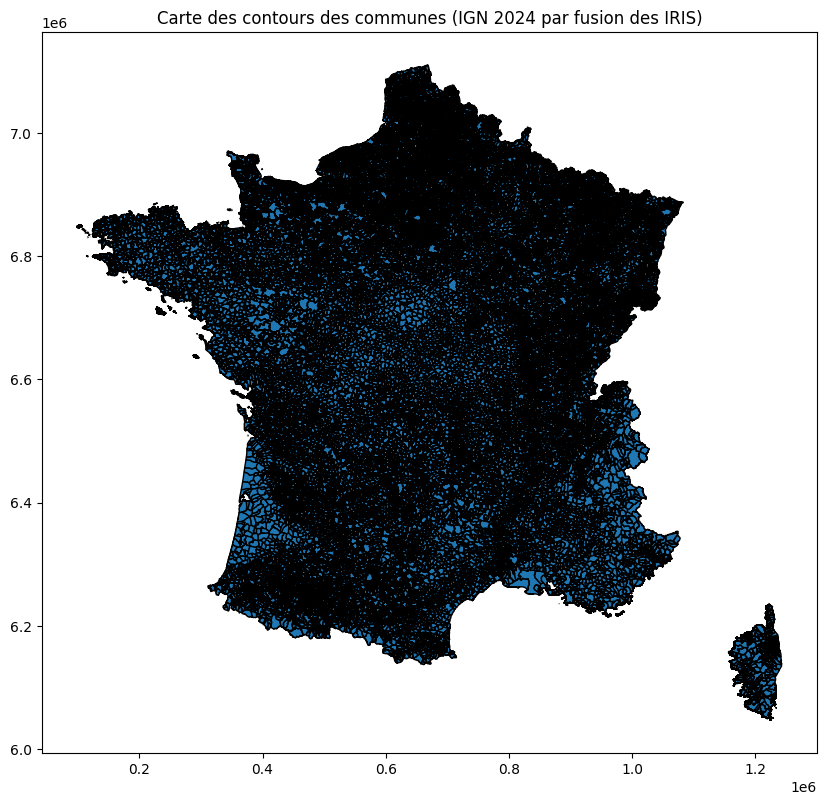

In [51]:
fig, ax = plt.subplots(figsize=(10, 10))
shp_ign_iris_communes.plot(ax=ax, edgecolor="black")
plt.title("Carte des contours des communes (IGN 2024 par fusion des IRIS)")
plt.show()

# Création des contours de départements

## Regroupement des contours par département

In [52]:
# Création de la colonne DEPARTEMENT
shp_ign_iris["INSEE_COM"] = shp_ign_iris["INSEE_COM"].astype(str)
shp_ign_iris["DEPARTEMENT"] = shp_ign_iris["INSEE_COM"].str[:2]

In [53]:
shp_ign_iris_departements = shp_ign_iris.dissolve(
    by="DEPARTEMENT", aggfunc="first"
).reset_index()

## Carte des départements

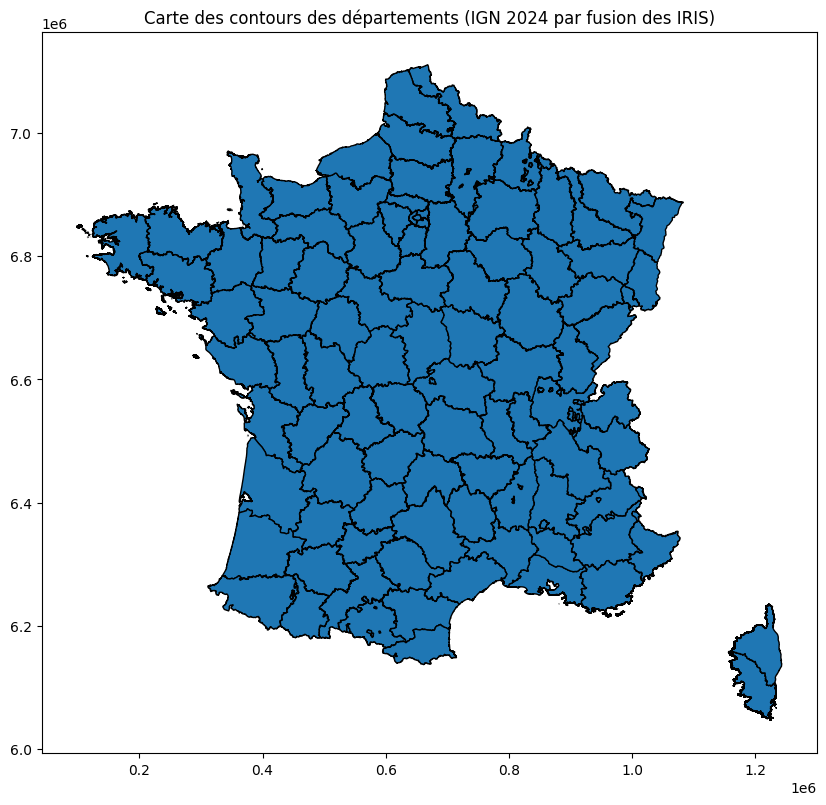

In [54]:
fig, ax = plt.subplots(figsize=(10, 10))
shp_ign_iris_departements.plot(ax=ax, edgecolor="black")
plt.title("Carte des contours des départements (IGN 2024 par fusion des IRIS)")
plt.show()

**--> Voir pourquoi il y a des trous dans la carte des départements**

# Synthèse des principaux résultats

## Découpage des données (codes INSEE)
- Dans la base IGN IRIS : données découpées selon les codes INSEE des communes lorsqu’elles n’ont pas d’arrondissements, et des codes INSEE des arrondissements dans les villes qui en contiennent. Par exemple pour Marseille on a les codes INSEE des arrondissements (par exemple 13202) et pas le code INSEE de la ville de Marseille (13055).
- Dans la base EDC (→ présente dans duckdb) en revanche, les codes INSEE sont ceux des villes même lorsqu’il y a des arrondissements (pour Marseille on aura 13055 et pas les arrondissements comme par exemple 13202).
- Le lien entre les codes INSEE des communes et des arrondissements peut être fait via la colonne “COMPARENT” de la base de données COG INSEE.

## Quelles données dans les différentes bases ?
- Base IGN IRIS : contours des IRIS qui permettent d’avoir les contours supérieurs (communes, départements, régions) par regroupement d’IRIS.
1 version par an (dernière disponible = 2024) : cf. notebook dans lequel il y a les contours communes et départements.  
- Base COG INSEE : contient les codes INSEE, noms de communes, région, département. A la fois pour les communes et les arrondissements (permet donc de faire le lien entre la base IGN IRIS et la base EDC - voir la partie “Découpage des données”)
1 version par an (dernière disponible = 2024).
- Après vérification les communes des bases IGN IRIS 2024 et COG INSEE 2024 sont les mêmes, à l’exception des arrondissements (sujet détaillé plus haut) et des DROM (présents dans la base COG INSEE et pas dans la base IGN IRIS).

## Ecarts de communes avec la BDD duckdb
- Dans la BDD duckdb il y a 2 communes qui sont absentes de la base COG INSEE (je n’ai pas creusé pour le moment - est-ce qu’on a prévu de cartographier les DROM aussi ?) :  
    49534	duckdb	97701	SAINT-BARTHELEMY	Toute la commune	971000159	SAINT-BARTHELEMY	2010-10-19	2024	2025-02-09  
    49535	duckdb	97801	SAINT-MARTIN	Toute la commune	971000160	SAINT-MARTIN	2010-10-19	2024	2025-02-09  

- A l’inverse il y a 132 communes présentes dans la base INSEE mais qui ne sont pas dans la base duckdb (possible de transmettre la liste si besoin).
- Pour rappel les communes présentes dans la base COG INSEE et la base IGN IRIS sont les mêmes (à l’exception des arrondissements mais qui peuvent être gérés sans problème) - cf. dernier point de la partie “Quelles données dans les différentes bases ?” → donc le croisement des communes duckdb - IGN IRIS donnera le même résultat que le croisement duckdb - COG INSEE.

## Population
- --> Pour trier les communes par ordre décroissant de la population lors de la frappe pour une recherche.
- Exploration prévue : croisement des communes de la base populations avec les communes présentes en base pour s’assurer qu’on puisse attribuer une population à chaque commune.